In [5]:
import pandas as pd
import math
import numpy as np
import time

import seaborn as sns

In [6]:
name = 'NBA'
output_folder  = '{}/{}'.format('data', name)
simFile = '{}/similarity'.format(output_folder)

In [7]:
insight_df = pd.read_csv('./rawData/{}/insight.csv'.format(name))
subspace_df = pd.read_csv('./rawData/{}/subspace.csv'.format(name))

# insight_columns: insights columns
# subspace_columns: subspaces

insight_columns = insight_df.columns[:10]
subspace_columns = subspace_df.columns

result_df = insight_df[insight_columns].merge(subspace_df, left_on='sid', right_on='sid')
result_df['index'] = result_df.index

In [8]:
# A: features used  to calculate similarity
# M: the size of data

A = ['breakdown', 'measure'] + list(subspace_columns)[:-1]
N = result_df.shape[0]

In [9]:
# function f(k, x); funciton p(k, x) p2(k, x)

kx_map = {}
for (k, a) in enumerate(A):
    if k not in kx_map:
        kx_map[k] = {}
    x_count = result_df[[a, 'index']].groupby(a).count().reset_index()
    for obj in x_count.to_dict('records'):
        kx_map[k][obj[a]] = obj['index']
        
        
def f(k, x):
    if k not in kx_map:
        return False
    if x not in kx_map[k]:
        return 0
    return kx_map[k][x]

insight_records= result_df.to_dict('records')

def p(k, x):
    fkx = f(k, x)
    if fkx == False:
        return False
    return fkx / N

def p2(k, x):
    fkx = f(k,x)
    if fkx == False:
        return False
    return fkx * (fkx-1) / (N * (N-1)) 

def linw(src, dst):
    s = 0
    for (k, a) in enumerate(A):
        Xk, Yk =  src[a], dst[a]
        s += (np.log(p(k, Xk)) + np.log(p(k, Yk))) 
    return 1/s 

def linS(k, src, dst):
    key = A[k]
    Xk, Yk = src[key], dst[key]
    if Xk == Yk:
        return 2 * np.log(p(k, Xk))
    return 2*np.log2(p(k, Xk) + p(k, Yk))

def lin(src, dst):
    w = linw(src, dst)
    sim = 0
    for (k, a) in enumerate(A):
        sim += w*(linS(k, src, dst))
    return sim


In [10]:
simMatrix = np.zeros((N, N))
start_time = time.time()

for i in range(0, len(insight_records)):
    src = insight_records[i]
    for j in range(i+1, len(insight_records)):
        dst = insight_records[j]
        simMatrix[i][j] = float(lin(src, dst))
        simMatrix[j][i] = simMatrix[i][j]

end_time = time.time()
print('use time ', end_time - start_time)

use time  7.232942819595337


In [11]:
np.savez(simFile, sim = simMatrix)

In [13]:
simFile

'data/NBA/similarity'

In [17]:
up = np.load("{}.npz".format(simFile))

## Calculate projection

In [19]:
import numpy as np
from sklearn.manifold import TSNE

In [23]:
def generate_projection(sim_matrix, perplexity = 12):
    X_embedded = TSNE(n_components=2, 
                   init='random', perplexity=perplexity).fit_transform(sim_matrix)
    return X_embedded

def visualize_matrix(projection):
    df = pd.DataFrame(columns=['x', 'y'], data=projection)
    sns.scatterplot(data=df, x="x", y="y")

def calc_projection(sim, index_list, perplexity = 50):
    matrix = sim if type(sim) != str else np.load(simFile.format(output_folder, 'npz'))
    sub_matrix = matrix[index_list][:, index_list]
    X_embedded = generate_projection(sub_matrix, perplexity)
    return X_embedded

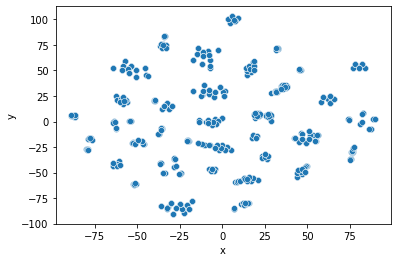

In [31]:
projection = calc_projection(simMatrix, [i for i in range(0, 650)], perplexity=5)
visualize_matrix(projection)

In [32]:
np.savez("{}/{}.npz".format(output_folder, 'projection'), projection = projection)

In [ ]:
type('123') == str

In [ ]:
emb = calc_projection(simMatrix, [i for i in range(0, 649)], perplexity=12)
visualize_matrix(emb)

In [ ]:
test_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_index = [i for i in range(0, 374)]
sub_similarity = simMatrix[test_index][:, test_index]

In [ ]:
sub_similarity

In [ ]:
X_embedded = generate_projection(sub_similarity, 99)
visualize_matrix(X_embedded)

In [ ]:
simMatrix[[1,2,3]][:, [1,2,3]].shape

In [ ]:
simMatrix[[1,5,7]][:, [1,5,7]]

In [ ]:
simMatrix[[1]]

## Save similarity matrix

In [ ]:

start_time = time.time()
X_embedded = TSNE(n_components=2, 
                   init='random', perplexity=12).fit_transform(simMatrix)
print("Use time: ", time.time() - start_time)

projection = pd.DataFrame(columns=['x', 'y'], data = X_embedded)
sns.scatterplot(data=projection, x="x", y="y")

In [ ]:
result_df[['x', 'y']] = projection.values
result_df.to_csv('projection.csv', index = False)

In [ ]:
def generate_projection():
    pass

## process subspace

In [ ]:
sub_df = result_df[result_df['team_name'] == 'Los Angeles Lakers']

sub_N = sub_df.shape[0]
sub_simMatrix = np.zeros((sub_N, sub_N))
start_time = time.time()
sub_insight_records = sub_df.to_dict('records')
for i in range(0, len(sub_insight_records)):
    src = sub_insight_records[i]
    for j in range(i+1, len(sub_insight_records)):
        dst = sub_insight_records[j]
        sub_simMatrix[i][j] = float(lin(src, dst))
        sub_simMatrix[j][i] = sub_simMatrix[i][j]

end_time = time.time()
print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
sub_embedded = TSNE(n_components=2, 
                   init='random', perplexity=5).fit_transform(sub_simMatrix)
print("Use time: ", time.time() - start_time)

sub_projection = pd.DataFrame(columns=['x', 'y'], data = sub_embedded)
sns.scatterplot(data=sub_projection, x="x", y="y")

In [ ]:
sub_df[['x', 'y']] = sub_projection.values
sub_df.to_csv('subspace.csv', index = False)

## breakdown subspace

In [ ]:
result_df['breakdown'].unique()

In [ ]:
result_df[['breakdown','age']].groupby('breakdown').count()

In [ ]:
result_df[['lg_name','age']].groupby('lg_name').count()

In [ ]:
breakdown_df = result_df[result_df['breakdown'] == 'lg_name']

breakdown_N = breakdown_df.shape[0]
breakdown_simMatrix = np.zeros((breakdown_N, breakdown_N))
start_time = time.time()
breakdown_insight_records = breakdown_df.to_dict('records')
for i in range(0, len(breakdown_insight_records)):
    src = breakdown_insight_records[i]
    for j in range(i+1, len(breakdown_insight_records)):
        dst = breakdown_insight_records[j]
        breakdown_simMatrix[i][j] = float(lin(src, dst))
        breakdown_simMatrix[j][i] = breakdown_simMatrix[i][j]
        

end_time = time.time()
print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
breakdown_embedded = TSNE(n_components=2, 
                   init='random', perplexity=50).fit_transform(breakdown_simMatrix)
print("Use time: ", time.time() - start_time)

breakdown_projection = pd.DataFrame(columns=['x', 'y'], data = breakdown_embedded)
sns.scatterplot(data=breakdown_projection, x="x", y="y")

In [ ]:
breakdown_df[['x', 'y']] = breakdown_projection.values
breakdown_df.to_csv('breakdown.csv', index = False)

## breakdown  and  subspace

In [ ]:
bs_df = result_df[(result_df['breakdown'] == 'lg_name')&(result_df['team_name'] == 'Los Angeles Lakers')]

bs_N = bs_df.shape[0]
bs_simMatrix = np.zeros((bs_N, bs_N))
start_time = time.time()
bs_insight_records = bs_df.to_dict('records')
for i in range(0, len(bs_insight_records)):
    src = bs_insight_records[i]
    for j in range(i+1, len(bs_insight_records)):
        dst = bs_insight_records[j]
        bs_simMatrix[i][j] = float(lin(src, dst))
        bs_simMatrix[j][i] = bs_simMatrix[i][j]
        

# end_time = time.time()
# print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
bs_embedded = TSNE(n_components=2, 
                   init='random', perplexity=50).fit_transform(bs_simMatrix)
print("Use time: ", time.time() - start_time)

bs_projection = pd.DataFrame(columns=['x', 'y'], data = bs_embedded)
sns.scatterplot(data=bs_projection, x="x", y="y")

In [ ]:
bs_df[['x', 'y']] = bs_projection.values
bs_df.to_csv('bs.csv', index = False)

In [35]:
result_df['year'].shape

(650,)